In [47]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler
import numpy as np


import torch
from transformers import BertTokenizer, BertModel



In [48]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [49]:
def visualize_clusters(combined_vectors, labels, Kc):
    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2)
    tsne_vectors = tsne.fit_transform(combined_vectors)

    # Visualize the clusters using scatter plot
    plt.scatter(Kc[:, 0], Kc[:, 1], color='red', marker='*', label='Centroids')
    plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1], c=labels, label='Data Points')
    plt.title("Cluster Visualization")
    plt.legend()  # Add legend to differentiate centroids and data points
    plt.show()

def create_elbow_plot(combined_vectors):
    # Calculate the within-cluster sum of squares (WCSS) for a range of k values
    k_range = range(2, 100)
    wcss = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(combined_vectors)
        wcss.append(kmeans.inertia_)

    # Plot the elbow plot
    plt.plot(k_range, wcss)
    plt.title("Elbow Plot")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
    plt.show()
    
def calculate_cohesion(data, labels):
    cohesion_scores = []
    for cluster_label in np.unique(labels):
        cluster_data = data[labels == cluster_label]
        pairwise_distances = np.linalg.norm(cluster_data[:, np.newaxis] - cluster_data, axis=2)
        average_distance = np.mean(pairwise_distances)
        cohesion_scores.append(average_distance)
    return cohesion_scores

def calculate_separation(data, labels):
    separation_scores = []
    for cluster1_label in np.unique(labels):
        cluster1_data = data[labels == cluster1_label]
        for cluster2_label in np.unique(labels):
            if cluster1_label != cluster2_label:
                cluster2_data = data[labels == cluster2_label]
                pairwise_distances = np.linalg.norm(cluster1_data[:, np.newaxis] - cluster2_data, axis=2)
                average_distance = np.mean(pairwise_distances)
                separation_scores.append(average_distance)
    return separation_scores


In [50]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

In [51]:
# Load a pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.to(device)  # Move the model to the GPU if available

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [53]:
with open('title_bert_embeddings.pkl', 'rb') as f:
    title_embeddings = pickle.load(f)

with open('abstract_bert_embeddings.pkl', 'rb') as f:
    abstract_embeddings = pickle.load(f)

In [54]:
title_embeddings = np.array(title_embeddings)
abstract_embeddings = np.array(abstract_embeddings)

# Combine the title and abstract embeddings
combined_embeddings = np.vstack((title_embeddings, abstract_embeddings))

In [55]:
print(combined_embeddings)

[[ 0.24021314  0.66669476  0.6395514  ... -0.37506363 -0.06366593
  -0.12442446]
 [ 0.30126035  0.6045452   0.40460783 ... -0.33561763 -0.00267397
  -0.2572105 ]
 [ 0.1786899   0.6085371   0.75771034 ... -0.32150438 -0.1120196
  -0.28715935]
 ...
 [ 0.13740896  0.58971685  0.6583762  ... -0.02501111 -0.07627814
  -0.43923044]
 [ 0.16573411  0.59571594  0.65026635 ... -0.01409275 -0.09191445
  -0.33164507]
 [ 0.17260884  0.73726445  0.5940435  ...  0.05676374 -0.0841399
  -0.5092465 ]]


In [56]:
def calculate_inertia(data, labels, centers):
    inertia = 0
    for cluster_label in np.unique(labels):
        cluster_data = data[labels == cluster_label]
        inertia += np.sum(np.square(pairwise_distances(cluster_data, [centers[cluster_label]], metric='euclidean')))
    return inertia

def calculate_dunn_index(data, labels, centers):
    min_inter_cluster_distances = np.min([np.min(pairwise_distances(data[labels == i], data[labels != i])) for i in np.unique(labels)])
    max_intra_cluster_diameters = np.max([np.max(pairwise_distances(data[labels == i])) for i in np.unique(labels)])
    dunn_index = min_inter_cluster_distances / max_intra_cluster_diameters
    return dunn_index

In [57]:
'''# Set the desired silhouette score threshold
desired_silhouette_score = 0.7

# Initialize silhouettes with a value below the threshold
silhouettes = 0.5

# Specify the range of k values to evaluate
ks = range(2, 11)
cluster_centers_list = []

# Iterate until the silhouette score is greater than or equal to the threshold
while silhouettes < desired_silhouette_score:
    best_silhouette = 0  # Initialize the best silhouette score for the current iteration

    # Iterate over the range of k values
    for k in ks:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(combined_embeddings)
        silhouette = silhouette_score(combined_embeddings, kmeans.labels_)

        # Check if the current silhouette score is better than the best so far
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_k = k
            best_labels = kmeans.labels_
            best_cluster_centers = kmeans.cluster_centers_

    # Update the silhouette score for the current iteration
    silhouettes = best_silhouette

# Obtain y_predicted and cluster_centers for the optimal number of clusters
kmeans = KMeans(n_clusters=best_k, n_init=50, max_iter=100)
kmeans.fit(combined_embeddings)
y_predicted = kmeans.labels_
cluster_centers = kmeans.cluster_centers_'''

'# Set the desired silhouette score threshold\ndesired_silhouette_score = 0.7\n\n# Initialize silhouettes with a value below the threshold\nsilhouettes = 0.5\n\n# Specify the range of k values to evaluate\nks = range(2, 11)\ncluster_centers_list = []\n\n# Iterate until the silhouette score is greater than or equal to the threshold\nwhile silhouettes < desired_silhouette_score:\n    best_silhouette = 0  # Initialize the best silhouette score for the current iteration\n\n    # Iterate over the range of k values\n    for k in ks:\n        kmeans = KMeans(n_clusters=k)\n        kmeans.fit(combined_embeddings)\n        silhouette = silhouette_score(combined_embeddings, kmeans.labels_)\n\n        # Check if the current silhouette score is better than the best so far\n        if silhouette > best_silhouette:\n            best_silhouette = silhouette\n            best_k = k\n            best_labels = kmeans.labels_\n            best_cluster_centers = kmeans.cluster_centers_\n\n    # Update the

In [58]:
# Set the desired silhouette score threshold
desired_silhouette_score = 0.4

# Initialize silhouettes with a value below the threshold
silhouettes = 0.3

# Specify the range of k values to evaluate
ks = range(2, 10)
cluster_centers_list = []
best_silhouette = 0  # Initialize the best silhouette score for the current iteration

# Iterate until the silhouette score is greater than or equal to the threshold
while silhouettes < desired_silhouette_score:

    
    # Iterate over the range of k values
    for k in ks:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, max_iter=1000)
        kmeans.fit(combined_embeddings)
        silhouette = silhouette_score(combined_embeddings, kmeans.labels_)

        # Check if the current silhouette score is better than the best so far
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_k = k
            best_labels = kmeans.labels_
            best_cluster_centers = kmeans.cluster_centers_

    # Calculate Inertia and Dunn Index for the best clustering
    inertia = calculate_inertia(combined_embeddings, best_labels, best_cluster_centers)
    dunn_index = calculate_dunn_index(combined_embeddings, best_labels, best_cluster_centers)

    # Print or store Inertia and Dunn Index for analysis
    print("For k =", best_k)
    print("Silhouette score:", best_silhouette)
    print("Inertia:", inertia)
    print("Dunn Index:", dunn_index)

    # Update the silhouette score for the current iteration
    silhouettes = best_silhouette
    ks = range(best_k, best_k + 10)


# Obtain y_predicted and cluster_centers for the optimal number of clusters
kmeans = KMeans(n_clusters=best_k, n_init=50, max_iter=100)
kmeans.fit(combined_embeddings)
y_predicted = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

For k = 2
Silhouette score: 0.42396143
Inertia: 3468.9310913085938
Dunn Index: 0.35770625


In [59]:
# Evaluate the clustering using silhouette score, cohesion, and separation
silhouette_avg = silhouette_score(combined_embeddings, kmeans.labels_)
cohesion_avg = calculate_cohesion(combined_embeddings, kmeans.labels_)
separation_avg = calculate_separation(combined_embeddings, kmeans.labels_)

print("Silhouette score:", silhouette_avg)
print("Cohesion:", cohesion_avg)
print("Separation:", separation_avg)

Silhouette score: 0.42396143
Cohesion: [4.010266, 2.1346004]
Separation: [5.391888, 5.3918896]


In [60]:
Kc = kmeans.cluster_centers_

In [61]:
print(Kc)

[[ 0.13142374  0.5116927   0.5455055  ... -0.20624657 -0.0491585
  -0.19573903]
 [ 0.13104111  0.6643877   0.648507   ...  0.04333185 -0.02927389
  -0.47050506]]


C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


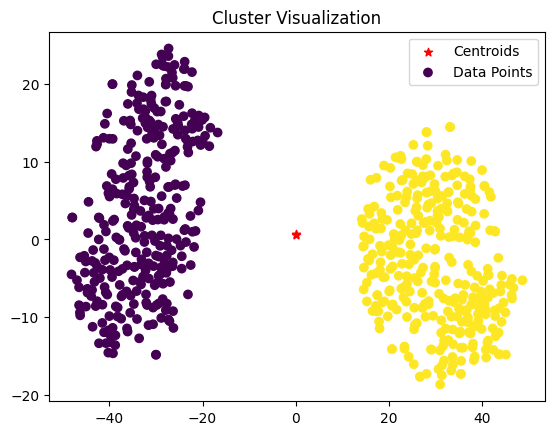

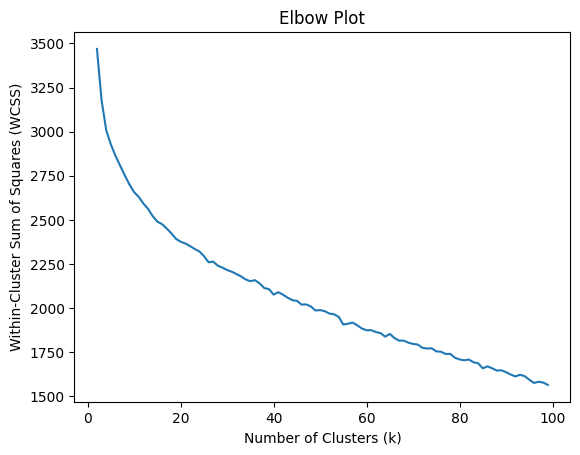

In [62]:
# Visualize the clusters
visualize_clusters(combined_embeddings, kmeans.labels_, Kc)

# Create the elbow plot
create_elbow_plot(combined_embeddings)

In [63]:
def recluster(data, n_clusters, n_iterations=10):
    best_inertia = float("inf")
    best_labels = None
    best_cluster_centers = None
    best_dunn_index = float("-inf")

    for _ in range(n_iterations):
        kmeans = KMeans(n_clusters=n_clusters, n_init=50)
        kmeans.fit(data)
        inertia = kmeans.inertia_

        # Calculate Dunn index
        dunn_index = calculate_dunn_index(data, kmeans.labels_)

        if inertia < best_inertia and dunn_index > best_dunn_index:
            best_inertia = inertia
            best_labels = kmeans.labels_
            best_cluster_centers = kmeans.cluster_centers_
            best_dunn_index = dunn_index

    return best_labels, best_cluster_centers, best_inertia, best_dunn_index


In [64]:
# Use recluster function to refine the clustering
refined_y_predicted, refined_cluster_centers, refined_inertia, refined_dunn_index = recluster(combined_embeddings, best_k)

# Evaluate the refined clustering using silhouette score, cohesion, and separation
refined_silhouette_avg = silhouette_score(combined_embeddings, refined_y_predicted)
refined_cohesion_avg = calculate_cohesion(combined_embeddings, refined_y_predicted)
refined_separation_avg = calculate_separation(combined_embeddings, refined_y_predicted)

print("Refined Silhouette score:", refined_silhouette_avg)
print("Refined Cohesion:", refined_cohesion_avg)
print("Refined Separation:", refined_separation_avg)
print("Refined Inertia:", refined_inertia)
print("Refined Dunn Index:", refined_dunn_index)

# Visualize the refined clusters with centroids
visualize_clusters(combined_embeddings, refined_y_predicted, refined_cluster_centers)


TypeError: calculate_dunn_index() missing 1 required positional argument: 'centers'